Approach 3– Multivariate GRU

Input features: Open, High, Low, Close, Volume

Target variable: Close

Lookback window: 90

Layers: 3

Units: 128

Dropout: 0.3

Optimizer: Adam (learning rate = 0.0005 with gradient clipping)

Loss: MSE

Batch size: 16

Epochs: up to 200

In [ ]:
import os, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Model
from IPython.display import display

np.random.seed(42)
tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

TensorFlow: 2.19.0


In [ ]:
# ====================== Config (Multivariate GRU) ======================
CSV_PATH    = "../dataset/TSLA.csv"   # change if needed
DATE_COL    = "Date"
CLOSE_COL   = "Close"
TRAIN_START = "2015-01-12"

# Features for multivariate input
FEATURE_COLS = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
CLOSE_IDX    = FEATURE_COLS.index(CLOSE_COL)  # index of Close in the feature vector

# Hyperparameters
LOOKBACK    = 90
EPOCHS      = 200
BATCH_SIZE  = 16

GRU_UNITS   = 128
GRU_LAYERS  = 3
GRU_DROPOUT = 0.3

TRAIN_RATIO = 0.80
VAL_RATIO   = 0.10
TEST_RATIO  = 0.10

In [ ]:
CSV_PATH = "/content/TSLA.csv" # Update this path after uploading the file
import os
print(os.path.exists(CSV_PATH))

True


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-12,13.536667,13.631333,13.283333,13.480667,13.480667,89254500
2015-01-13,13.554667,13.840667,13.394000,13.616667,13.616667,67159500
2015-01-14,12.388667,13.013333,12.333333,12.846000,12.846000,173278500


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-11,173.919998,174.750000,167.410004,170.660004,170.660004,64761900
2024-06-12,171.119995,180.550003,169.800003,177.289993,177.289993,89884800
2024-06-13,188.427994,191.050003,181.940094,184.434998,184.434998,97297153


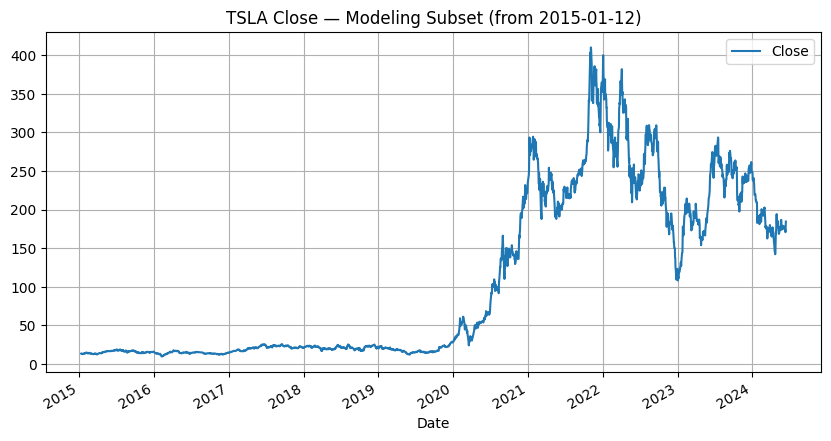

In [ ]:
# ====================== Load, clean, plot ======================
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Update CSV_PATH.")

df = pd.read_csv(CSV_PATH)
if DATE_COL not in df.columns or CLOSE_COL not in df.columns:
    raise ValueError(
        f"Expected '{DATE_COL}' and '{CLOSE_COL}' in columns: {df.columns.tolist()}"
    )

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True).set_index(DATE_COL)

df = df[df.index >= TRAIN_START].copy()

# Handle missing values in all feature columns
if df[FEATURE_COLS].isna().any().any():
    df[FEATURE_COLS] = (
        df[FEATURE_COLS]
        .interpolate(method="time")
        .fillna(method="bfill")
        .fillna(method="ffill")
    )

display(df[FEATURE_COLS].head(3))
display(df[FEATURE_COLS].tail(3))

df[[CLOSE_COL]].plot(title=f"TSLA Close — Modeling Subset (from {TRAIN_START})")
plt.show()

In [ ]:
# ====================== Chronological 80/10/10 split (no leakage) ======================
feature_values = df[FEATURE_COLS].values.astype("float32")  # (N, D)
n = len(feature_values)
n_train = int(np.floor(TRAIN_RATIO * n))
n_val   = int(np.floor(VAL_RATIO   * n))
n_test  = n - n_train - n_val

assert n_train > LOOKBACK and n_val > 0 and n_test > 0, \
    "Not enough data for chosen LOOKBACK/splits."

train_raw = feature_values[:n_train]
val_raw   = feature_values[n_train:n_train+n_val]
test_raw  = feature_values[n_train+n_val:]

# Scale ALL features together
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_raw)   # fit on TRAIN only

train_scaled = scaler.transform(train_raw)
val_scaled   = scaler.transform(val_raw)
test_scaled  = scaler.transform(test_raw)

print(f"Total: {n} | Train: {n_train} | Val: {n_val} | Test: {n_test}")

Total: 2372 | Train: 1897 | Val: 237 | Test: 238


In [ ]:
# ====================== Windowing util (multivariate) ======================
def make_xy_multivar(features_scaled, lookback, close_idx):
    """
    features_scaled: array (N, D)
    Returns:
      X: (samples, lookback, D)
      y: (samples,) -- scaled Close
    """
    X, y = [], []
    for i in range(lookback, len(features_scaled)):
        X.append(features_scaled[i - lookback:i, :])
        y.append(features_scaled[i, close_idx])  # target = Close (scaled)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y


# Train windows from TRAIN only
X_train, y_train = make_xy_multivar(train_scaled, LOOKBACK, CLOSE_IDX)

# Validation windows need LOOKBACK context from the end of train
val_with_ctx = np.concatenate([train_scaled[-LOOKBACK:], val_scaled], axis=0)
X_val, y_val = make_xy_multivar(val_with_ctx, LOOKBACK, CLOSE_IDX)

# Test windows need LOOKBACK context from the end of val
test_with_ctx = np.concatenate([val_scaled[-LOOKBACK:], test_scaled], axis=0)
X_test, y_test = make_xy_multivar(test_with_ctx, LOOKBACK, CLOSE_IDX)

print(
    "Shapes:",
    "\n  X_train", X_train.shape, "y_train", y_train.shape,
    "\n  X_val  ", X_val.shape,   "y_val  ", y_val.shape,
    "\n  X_test ", X_test.shape,  "y_test ", y_test.shape,
)

Shapes: 
  X_train (1807, 90, 6) y_train (1807,) 
  X_val   (237, 90, 6) y_val   (237,) 
  X_test  (238, 90, 6) y_test  (238,)


In [ ]:
# ====================== GRU model (multivariate) ======================
def build_gru_multivar(
    lookback=90,
    num_features=None,
    gru_units=128,
    num_layers=3,
    dropout=0.3,
):
    if num_features is None:
        raise ValueError("num_features must be provided")

    inp = layers.Input(shape=(lookback, num_features))
    x = inp

    # First (num_layers - 1) GRU layers with return_sequences=True
    for i in range(max(0, num_layers - 1)):
        x = layers.GRU(gru_units, return_sequences=True)(x)
        x = layers.Dropout(dropout)(x)

    # Last GRU layer without return_sequences
    x = layers.GRU(gru_units, return_sequences=False)(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(1)(x)  # predict scaled Close

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model

In [ ]:
# ====================== Timing & per-epoch Test evaluation ======================
class TimeAndTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test, self.y_test = X_test, y_test
        self.cum_times = []
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []
        self._t0 = None

    def on_train_begin(self, logs=None):
        self._t0 = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        t_now = time.perf_counter()
        self.cum_times.append(t_now - self._t0)
        self.train_losses.append(float(logs.get("loss", np.nan)))
        self.val_losses.append(float(logs.get("val_loss", np.nan)))
        test_loss = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        self.test_losses.append(float(test_loss))

    def to_frame(self):
        df_log = pd.DataFrame({
            "epoch": np.arange(1, len(self.cum_times) + 1),
            "time_sec_cum": self.cum_times,
            "train_loss": self.train_losses,
            "val_loss": self.val_losses,
            "test_loss": self.test_losses,
        })
        df_log["train_rmse"] = np.sqrt(df_log["train_loss"])
        df_log["test_rmse"]  = np.sqrt(df_log["test_loss"])
        return df_log


def timed_fit(model, X_train, y_train, X_val, y_val, X_test, y_test,
              epochs=EPOCHS, batch_size=BATCH_SIZE):
    tcb = TimeAndTestCallback(X_test, y_test)
    es  = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size,
        verbose=1, shuffle=False,
        callbacks=[tcb, es]
    )
    return hist, tcb.to_frame()

In [ ]:
# ====================== Train GRU (multivariate) ======================
num_features = X_train.shape[2]

gru_multi = build_gru_multivar(
    lookback=LOOKBACK,
    num_features=num_features,
    gru_units=GRU_UNITS,
    num_layers=GRU_LAYERS,
    dropout=GRU_DROPOUT,
)
print(gru_multi.summary())

_, log_df_gru = timed_fit(
    gru_multi, X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=EPOCHS, batch_size=BATCH_SIZE
)

display(log_df_gru.head())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 90, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 90, 128)        │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 90, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,497 (978.50 KB)

 Trainable params: 250,497 (978.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 276ms/step - loss: 7.1383e-04 - val_loss: 0.0079
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 267ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/step - loss: 0.0090 - val_loss: 0.0119
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 263ms/step - loss: 0.0144 - val_loss: 0.0160
Epoch 5/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - loss: 0.0295 - val_loss: 0.0109
Epoch 6/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - loss: 0.0125 - val_loss: 0.0072
Epoch 7/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - loss: 0.0101 - val_loss: 0.0045
Epoch 8/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 267ms/step - loss: 0.0071 - val_loss: 0.0031
Epoch 9/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 258ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 10/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 264ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 11/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 267ms/step - loss: 0.0017 - val_loss: 0.0014

,epoch,time_sec_cum,train_loss,val_loss,test_loss,train_rmse,test_rmse
0,1,36.284287,0.003466,0.007865,0.005771,0.058870,0.075969
1,2,76.229616,0.005170,0.007405,0.003531,0.071905,0.059421
2,3,115.990181,0.006998,0.011886,0.005578,0.083656,0.074683
3,4,157.472627,0.013429,0.015997,0.008614,0.115882,0.092810
4,5,187.410569,0.017020,0.010902,0.008375,0.130461,0.091513


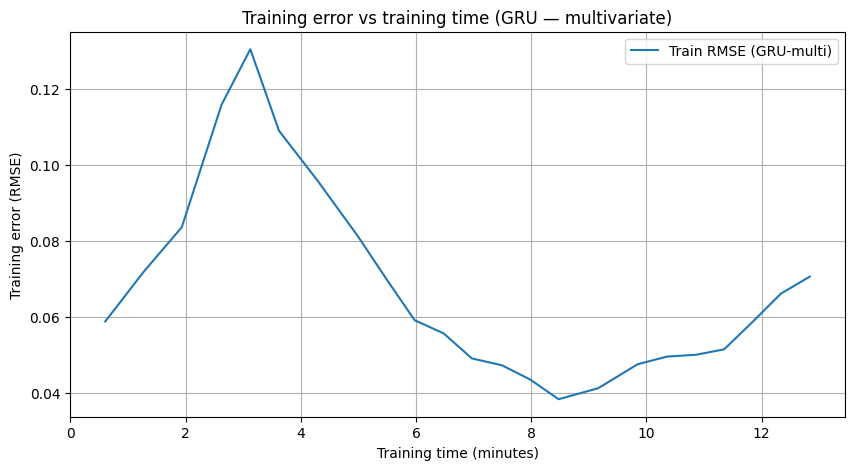

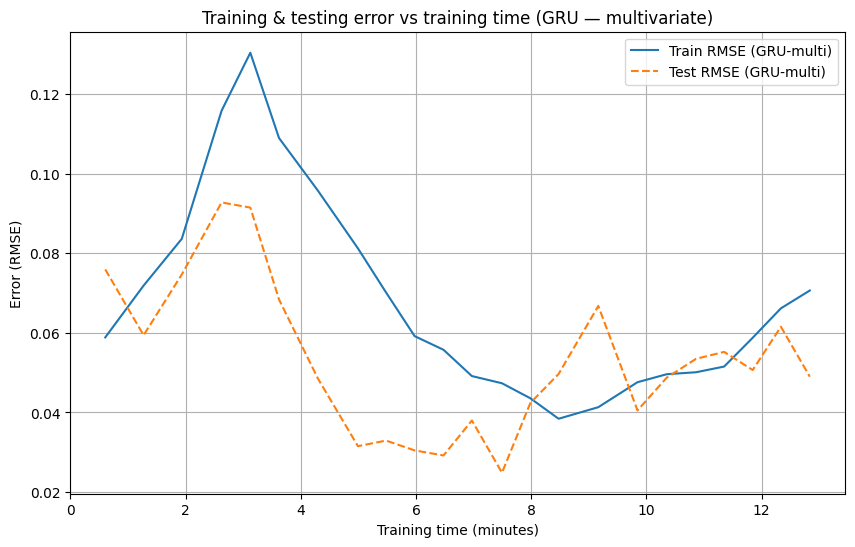

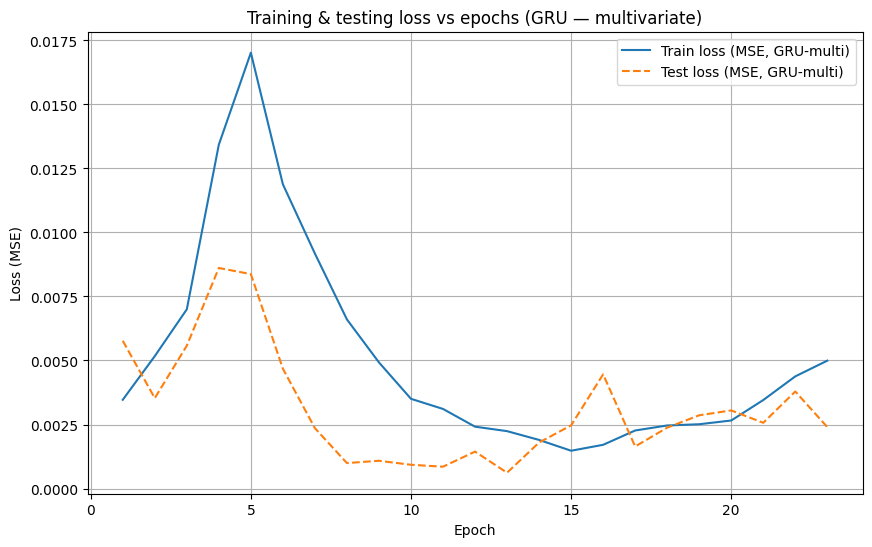

In [ ]:
# ====================== Required Plots (GRU multivariate) ======================
# 1) Training error vs training time
plt.figure(figsize=(10,5))
plt.plot(log_df_gru["time_sec_cum"]/60.0, log_df_gru["train_rmse"], label="Train RMSE (GRU-multi)")
plt.xlabel("Training time (minutes)")
plt.ylabel("Training error (RMSE)")
plt.title("Training error vs training time (GRU — multivariate)")
plt.legend()
plt.grid(True)
plt.show()

# 2) Training & testing error vs training time
plt.figure(figsize=(10,6))
plt.plot(log_df_gru["time_sec_cum"]/60.0, log_df_gru["train_rmse"], label="Train RMSE (GRU-multi)")
plt.plot(log_df_gru["time_sec_cum"]/60.0, log_df_gru["test_rmse"],  linestyle="--", label="Test RMSE (GRU-multi)")
plt.xlabel("Training time (minutes)")
plt.ylabel("Error (RMSE)")
plt.title("Training & testing error vs training time (GRU — multivariate)")
plt.legend()
plt.grid(True)
plt.show()

# 3) Loss (training & testing) vs epochs
plt.figure(figsize=(10,6))
plt.plot(log_df_gru["epoch"], log_df_gru["train_loss"], label="Train loss (MSE, GRU-multi)")
plt.plot(log_df_gru["epoch"], log_df_gru["test_loss"],  linestyle="--", label="Test loss (MSE, GRU-multi)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & testing loss vs epochs (GRU — multivariate)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ====================== Metrics helpers ======================
def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def collect_metrics(name, y_true, y_pred):
    return {
        "Model": name,
        "RMSE": rmse(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2":  r2_score(y_true, y_pred),
    }

In [ ]:
# ====================== Helper: inverse-transform CLOSE only ======================
def invert_close_from_scaled(scaled_close_1d):
    """
    scaled_close_1d: (N,) in the same scale as scaler (Close column).
    Returns: unscaled close (N,)
    """
    N = len(scaled_close_1d)
    D = len(FEATURE_COLS)
    tmp = np.zeros((N, D), dtype=np.float32)
    tmp[:, CLOSE_IDX] = scaled_close_1d
    inv = scaler.inverse_transform(tmp)
    return inv[:, CLOSE_IDX]


# ====================== TEST endpoint predictions & metrics for H in {1,7,15} ======================
def endpoint_results_for_H_gru_multi(model, H, use_val_context=True, model_name_prefix="GRU-multi"):
    """
    Endpoint-only forecasts for TEST at horizon H, using multivariate input.
    Other features are kept at their last observed scaled value; Close is updated with prediction.
    """
    scaled_full = scaler.transform(df[FEATURE_COLS].values.astype("float32"))  # (N, D)
    n_total = len(scaled_full)
    start_test = n_train + n_val

    if use_val_context:
        start_t = max(start_test, LOOKBACK)
    else:
        start_t = max(start_test + LOOKBACK, LOOKBACK)

    end_t = n_total - H
    dates, true_end, pred_end = [], [], []

    for t in range(start_t, end_t):
        window = scaled_full[t-LOOKBACK:t, :]  # (lookback, D)
        w = window.copy()

        for _ in range(H):
            inp = w.reshape(1, LOOKBACK, -1)
            p_scaled = model.predict(inp, verbose=0)[0, 0]  # predicted Close (scaled)

            new_step = w[-1, :].copy()
            new_step[CLOSE_IDX] = p_scaled  # update only Close
            w = np.vstack([w[1:], new_step])

        pred_end.append(p_scaled)
        true_end.append(scaled_full[t + H - 1, CLOSE_IDX])
        dates.append(df.index[t + H - 1])

    inv_true = invert_close_from_scaled(np.array(true_end))
    inv_pred = invert_close_from_scaled(np.array(pred_end))

    col_name = f"{model_name_prefix}(H={H})"
    results = pd.DataFrame(
        {"Actual": inv_true, col_name: inv_pred},
        index=pd.DatetimeIndex(dates, name="Date"),
    )
    m = collect_metrics(col_name, results["Actual"], results[col_name])
    print(f"Test metrics (H={H}): {m}")
    return results, m


# Run for H = 1, 7, 15 on TEST
results_1_g,  metrics_1_g  = endpoint_results_for_H_gru_multi(gru_multi, H=1,  use_val_context=True)
display(results_1_g.head())

results_7_g,  metrics_7_g  = endpoint_results_for_H_gru_multi(gru_multi, H=7,  use_val_context=True)
display(results_7_g.head())

results_15_g, metrics_15_g = endpoint_results_for_H_gru_multi(gru_multi, H=15, use_val_context=True)
display(results_15_g.head())

summary_test_gru = pd.DataFrame(
    [metrics_1_g, metrics_7_g, metrics_15_g]
)[["Model", "RMSE", "MSE", "MAE", "R2"]]

display(
    summary_test_gru
        .style.format({"RMSE": "{:.4f}", "MSE": "{:.4f}", "MAE": "{:.4f}", "R2": "{:.4f}"})
        .set_caption("TEST metrics by horizon (GRU — multivariate)")
)

Test metrics (H=1): {'Model': 'GRU-multi(H=1)', 'RMSE': 9.937909579683488, 'MSE': 98.76204681396484, 'MAE': 7.676637172698975, 'R2': 0.9275130033493042}


,Actual,GRU-multi(H=1)
Date,,
2023-07-06,276.540009,263.678253
2023-07-07,274.429993,264.118347
2023-07-10,269.609985,263.234680
2023-07-11,269.790009,260.761322
2023-07-12,271.989990,257.552673


Test metrics (H=7): {'Model': 'GRU-multi(H=7)', 'RMSE': 16.78580212787497, 'MSE': 281.7631530761719, 'MAE': 13.441786766052246, 'R2': 0.7854596376419067}


,Actual,GRU-multi(H=7)
Date,,
2023-07-14,281.380005,263.876678
2023-07-17,290.380005,259.454529
2023-07-18,293.339996,258.539795
2023-07-19,291.260010,255.168701
2023-07-20,262.899994,250.330048


Test metrics (H=15): {'Model': 'GRU-multi(H=15)', 'RMSE': 21.51039546445182, 'MSE': 462.6971130371094, 'MAE': 17.530920028686523, 'R2': 0.6194912791252136}


,Actual,GRU-multi(H=15)
Date,,
2023-07-26,264.350006,263.432129
2023-07-27,255.710007,259.045288
2023-07-28,266.440002,258.192505
2023-07-31,267.429993,255.015320
2023-08-01,261.070007,250.100616


,Model,RMSE,MSE,MAE,R2
0,GRU-multi(H=1),9.9379,98.7620,7.6766,0.9275
1,GRU-multi(H=7),16.7858,281.7632,13.4418,0.7855
2,GRU-multi(H=15),21.5104,462.6971,17.5309,0.6195


In [ ]:
# ====================== TRAIN endpoint metrics for H in {1,7,15} ======================
def endpoint_train_results_for_H_gru_multi(model, H, model_name_prefix="GRU-multi"):
    """
    Endpoint-only metrics on TRAIN at horizon H (purely train history).
    """
    scaled_full = scaler.transform(df[FEATURE_COLS].values.astype("float32"))
    n_total = len(scaled_full)

    start_t = LOOKBACK
    end_t   = n_train - H

    dates, true_end, pred_end = [], [], []

    for t in range(start_t, end_t):
        window = scaled_full[t-LOOKBACK:t, :]
        w = window.copy()

        for _ in range(H):
            inp = w.reshape(1, LOOKBACK, -1)
            p_scaled = model.predict(inp, verbose=0)[0, 0]
            new_step = w[-1, :].copy()
            new_step[CLOSE_IDX] = p_scaled
            w = np.vstack([w[1:], new_step])

        pred_end.append(p_scaled)
        true_end.append(scaled_full[t + H - 1, CLOSE_IDX])
        dates.append(df.index[t + H - 1])

    inv_true = invert_close_from_scaled(np.array(true_end))
    inv_pred = invert_close_from_scaled(np.array(pred_end))

    col_name = f"{model_name_prefix}(H={H})"
    results = pd.DataFrame(
        {"Actual": inv_true, col_name: inv_pred},
        index=pd.DatetimeIndex(dates, name="Date"),
    )

    m = collect_metrics(col_name, results["Actual"], results[col_name])
    print(f"Train metrics (H={H}): {m}")
    return results, m


train_res_1_g,  train_metrics_1_g  = endpoint_train_results_for_H_gru_multi(gru_multi, H=1)
train_res_7_g,  train_metrics_7_g  = endpoint_train_results_for_H_gru_multi(gru_multi, H=7)
train_res_15_g, train_metrics_15_g = endpoint_train_results_for_H_gru_multi(gru_multi, H=15)

summary_train_gru = pd.DataFrame(
    [train_metrics_1_g, train_metrics_7_g, train_metrics_15_g]
)[["Model", "RMSE", "MSE", "MAE", "R2"]]

display(
    summary_train_gru
        .style.format({"RMSE": "{:.4f}", "MSE": "{:.4f}", "MAE": "{:.4f}", "R2": "{:.4f}"})
        .set_caption("TRAIN metrics by horizon (GRU — multivariate)")
)

Train metrics (H=1): {'Model': 'GRU-multi(H=1)', 'RMSE': 19.428160751233793, 'MSE': 377.45343017578125, 'MAE': 17.323930740356445, 'R2': 0.966630220413208}
Train metrics (H=7): {'Model': 'GRU-multi(H=7)', 'RMSE': 26.705923684892106, 'MSE': 713.2063598632812, 'MAE': 22.647886276245117, 'R2': 0.9370731115341187}
Train metrics (H=15): {'Model': 'GRU-multi(H=15)', 'RMSE': 29.79500067846429, 'MSE': 887.7420654296875, 'MAE': 24.293996810913086, 'R2': 0.9218829274177551}


,Model,RMSE,MSE,MAE,R2
0,GRU-multi(H=1),19.4282,377.4534,17.3239,0.9666
1,GRU-multi(H=7),26.7059,713.2064,22.6479,0.9371
2,GRU-multi(H=15),29.7950,887.7421,24.2940,0.9219
